In [1]:
from __future__ import print_function
%matplotlib inline

### Index
[Import data](#1)   
[0. Generate datasets](#6)  
[1. k-fold cross-validation on posts](#7)  
[2. Train size: random set of posts](#8)  
[3. Leave one page out](#10)  
[4. Leave half pages out](#11)  

### <a id='1'></a> Import data

In [2]:
import json
import numpy as np
import pandas as pd

In [3]:
with open('../dataset/retweeters.json') as data_file:
    data = json.load(data_file)

print('Json length: %s' % len(data))

Json length: 15727


In [4]:
hoax_pages = {'844805327254011905','241488377','1359279284','1073461458','864116008910548992','2863515755','1045260886997430272','88763077','756161970160734208','930919729254010885'}

### <a id='6'></a> 0. Generate datasets

In [5]:
%%time
import df_utils

print('Full dataset:')
like_matrix, page, hoax = df_utils.cut_dataset(data,
                                                hoax_pages,
                                                min_post_like=0,
                                                min_user_like=0,
                                                print_results=True)
print('\nIntersection dataset:')
like_matrix_i, page_i, hoax_i = df_utils.filter_intersection(data,
                                                hoax_pages,
                                                print_results=True)
print()

Full dataset:
Posts with 0+ likes = 15727 (5698 hoax)
Users with 0+ likes = 11496
98782 non-zero values out of 180797592 (loading factor: 0.05%)

Intersection dataset:
Total users: 11496, Intersection users: 2167
54938 non-zero values out of 27221854 (loading factor: 0.20%)

Wall time: 4.78 s


### <a id='7'></a> 1. k-fold cross-validation on posts

In [6]:
%%time
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

def test_1(like_matrix, hoax):
    logreg = linear_model.LogisticRegression(C=1)
    return cross_val_score(logreg, like_matrix, hoax, cv=5)

score_test_1 = test_1(like_matrix, hoax)
print('Full dataset - mean: %.3f, std: %.3f' % (np.mean(score_test_1), np.std(score_test_1)))
score_test_1_i = test_1(like_matrix_i, hoax_i)
print('Intersection dataset - mean: %.3f, std: %.3f\n' % (np.mean(score_test_1_i), np.std(score_test_1_i)))

Full dataset - mean: 0.939, std: 0.001
Intersection dataset - mean: 0.914, std: 0.003

Wall time: 3.37 s


### <a id='8'></a> 2. Train size: random set of posts

In [7]:
%%time
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

def test_2(like_matrix, hoax, test_size, iterations=50):
    accuracy_list = []
    for seed in range(iterations):
        X_train, X_test, Y_train, Y_test = train_test_split(like_matrix, hoax, test_size=test_size, random_state=seed)
        logreg = linear_model.LogisticRegression(C=1)
        logreg.fit(X_train, Y_train)
        Y_pred = logreg.predict(X_test)
        accuracy_list.append(metrics.accuracy_score(Y_test, Y_pred))
    return accuracy_list

score_test_2 = test_2(like_matrix, hoax, 0.9)
print('Full dataset - mean: %.2f, std: %.2f' % (np.mean(score_test_2), np.std(score_test_2)))
score_test_2_i = test_2(like_matrix_i, hoax_i, 0.9)
print('Intersection dataset - mean: %.2f, std: %.2f' % (np.mean(score_test_2_i), np.std(score_test_2_i)))
print()

Full dataset - mean: 0.92, std: 0.00
Intersection dataset - mean: 0.89, std: 0.00

Wall time: 10.1 s


In [19]:
%%time
res_all_x = [1, 2, 5, 10, 20, 50, 100, 200, 400, 1000]
for i in res_all_x:
    print('train = %.4f train tweets full = %.1f train tweets intersection = %.1f test= %.4f' % ((1/float(i)), (1/float(i))*len(hoax), (1/float(i))*len(hoax_i), (1-(1/float(i)))) )
size_all = []
size_int = []
persent = []
for i in res_all_x:
    persent.append((1/float(i)))
    size_all.append((1/float(i))*len(hoax))
    size_int.append((1/float(i))*len(hoax_i))
print(persent)
print(size_all)
print(size_int)

train = 1.0000 train tweets full = 15727.0 train tweets intersection = 12562.0 test= 0.0000
train = 0.5000 train tweets full = 7863.5 train tweets intersection = 6281.0 test= 0.5000
train = 0.2000 train tweets full = 3145.4 train tweets intersection = 2512.4 test= 0.8000
train = 0.1000 train tweets full = 1572.7 train tweets intersection = 1256.2 test= 0.9000
train = 0.0500 train tweets full = 786.4 train tweets intersection = 628.1 test= 0.9500
train = 0.0200 train tweets full = 314.5 train tweets intersection = 251.2 test= 0.9800
train = 0.0100 train tweets full = 157.3 train tweets intersection = 125.6 test= 0.9900
train = 0.0050 train tweets full = 78.6 train tweets intersection = 62.8 test= 0.9950
train = 0.0025 train tweets full = 39.3 train tweets intersection = 31.4 test= 0.9975
train = 0.0010 train tweets full = 15.7 train tweets intersection = 12.6 test= 0.9990
[1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.0025, 0.001]
[15727.0, 7863.5, 3145.4, 1572.7, 786.35, 314.54, 157.2

In [9]:
res_all_x = [2, 5, 10, 20, 50, 100, 200, 400]
res_int_x = res_all_x
score_test_2 = [test_2(like_matrix, hoax, 1-(1/float(i))) for i in res_all_x]
score_test_2_i = [test_2(like_matrix_i, hoax_i, 1-(1/float(i))) for i in res_all_x]
print('Done\n')

Done



In [10]:
len(hoax_i)

12562

In [11]:
#Graph points
res_all_y = [np.mean(i) for i in score_test_2]
print('logi_res_all_y = %s' % str(res_all_y))
res_all_err = [np.std(i) for i in score_test_2]
print('logi_res_all_err = %s' % str(res_all_err))

res_int_y = [np.mean(i) for i in score_test_2_i]
print('logi_res_int_y = %s' % str(res_int_y))
res_int_err = [np.std(i) for i in score_test_2_i]
print('logi_res_int_err = %s' % str(res_int_err))

logi_res_all_y = [0.9345701932858597, 0.9259831505325069, 0.9167205934298833, 0.9068228364901947, 0.8884720690326346, 0.8723185613359025, 0.8514371525337081, 0.808389852116267]
logi_res_all_err = [0.0024486757316576385, 0.0022813016837548348, 0.002515714363507264, 0.004475572764453983, 0.009863661481339969, 0.01238009548686527, 0.02237856910107369, 0.06698978242554172]
logi_res_int_y = [0.9111224327336411, 0.9011741293532336, 0.8928586591190519, 0.8821032344561758, 0.8647940865892292, 0.8415100104526814, 0.8160160000000001, 0.7612034155294869]
logi_res_int_err = [0.002941655225596091, 0.002820259301581182, 0.004184118937850038, 0.004491790962440057, 0.010124917748065357, 0.017503170546246616, 0.02282316857931869, 0.056907337639747875]


[]

<Figure size 720x432 with 0 Axes>

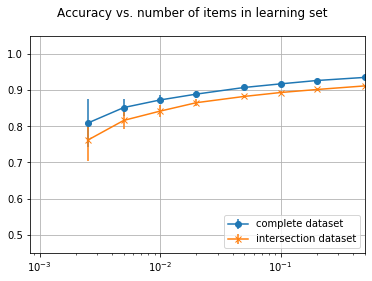

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
res_a_x = [1.0 / x for x in res_all_x]
res_i_x = [1.0 / x for x in res_int_x]
fig, ax = plt.subplots(1)
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='complete dataset')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='x', label='intersection dataset')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/2.0)
ax.legend(loc='lower right')
ax.grid()
fig.suptitle('Accuracy vs. number of items in learning set')
plt.plot()

### <a id='10'></a> 3. Leave one page out

In [13]:
%%time
from sklearn import linear_model
from sklearn import metrics
import df_utils

def test_3(like_matrix, hoax, page):
    accuracy_list = []
    for p in set(page):
        matrix_test, hoax_test, matrix_train, hoax_train = df_utils.split_pages(like_matrix, page, hoax, [str(p)])
        logreg = linear_model.LogisticRegression(C=1)
        logreg.fit(matrix_train, hoax_train)
        Y_pred = logreg.predict(matrix_test)
        acc = metrics.accuracy_score(hoax_test, Y_pred)
        accuracy_list.append(acc)
    return accuracy_list

score_test_3 = test_3(like_matrix, hoax, page)
print('Full dataset - mean: %.3f, std: %.3f' % (np.mean(score_test_3), np.std(score_test_3)))
score_test_3_i = test_3(like_matrix_i, hoax_i, page_i)
print('Intersection dataset - mean: %.3f, std: %.3f\n' % (np.mean(score_test_3_i), np.std(score_test_3_i)))

Full dataset - mean: 0.700, std: 0.372
Intersection dataset - mean: 0.683, std: 0.355

Wall time: 15.1 s


In [14]:
print(score_test_3)

[0.9827586206896551, 0.9420731707317073, 1.0, 0.12528735632183907, 0.6174469787915166, 0.2828282828282828, 0.9905660377358491, 0.0, 0.9217443249701314, 0.08832335329341318, 1.0, 0.9920136908157444, 0.8920863309352518, 0.5928853754940712, 0.1267605633802817, 0.968503937007874, 0.9969543147208122, 0.9963235294117647, 0.9868852459016394, 1.0, 0.4695852534562212, 0.12337662337662338, 1.0]


### <a id='11'></a> 4. Leave half pages out

In [15]:
from sklearn import linear_model
from sklearn import metrics
import df_utils
import random

pages_list = set(page)
hoax_pages = [p for p in pages_list if p in hoax_pages] #remove pages with no posts
not_hoax_pages = [p for p in pages_list if p not in hoax_pages]

accuracy_list = []
for seed in range(50):
    random.seed(seed)
    pages_tosplit = random.sample(hoax_pages, int(len(hoax_pages)/2.))
    pages_tosplit.extend(random.sample(not_hoax_pages, int(len(not_hoax_pages)/2.)))
    matrix_train, hoax_train, matrix_test, hoax_test = df_utils.split_pages(like_matrix, page, hoax, pages_tosplit)
    logreg = linear_model.LogisticRegression(C=1)
    logreg.fit(matrix_train, hoax_train)
    Y_pred = logreg.predict(matrix_test)
    acc = metrics.accuracy_score(hoax_test, Y_pred)
    accuracy_list.append(acc)
print('Full dataset - mean: %.3f, std: %.3f\n' % (np.mean(accuracy_list), np.std(accuracy_list)))

Full dataset - mean: 0.645, std: 0.098



In [16]:
print(accuracy_list)

[0.4074006562158221, 0.823004542504867, 0.7109596819988643, 0.6171290180537208, 0.8009700017962996, 0.6475198147653397, 0.6419952596423185, 0.5246795745841287, 0.5623952095808383, 0.5344457687723481, 0.6516561593115181, 0.5207474580928827, 0.6632140615191463, 0.6351823542258135, 0.7431262729124236, 0.7678264939928225, 0.6659316427783903, 0.4271333255296734, 0.6150611620795107, 0.7595933092817317, 0.6781672646977643, 0.6046071001196649, 0.6051224944320712, 0.5874172185430464, 0.6683651186490027, 0.8662965019433648, 0.536729751547224, 0.5830698126976405, 0.6686613763496813, 0.6301862556197816, 0.5804894476874719, 0.614116652578191, 0.6125369603784743, 0.45601397074874483, 0.7284069097888676, 0.6711547792333818, 0.6847749234032524, 0.7604758042714247, 0.6483153872872525, 0.5591612581128308, 0.7158226187352401, 0.6872551279096566, 0.7318355640535373, 0.6119282148158143, 0.6425992779783394, 0.5515793157756584, 0.7527932960893855, 0.6113847837985769, 0.6304047042545832, 0.8511761881901104]


In [17]:
from sklearn import linear_model
from sklearn import metrics
import df_utils
import random

pages_list = set(page_i)
hoax_pages = [p for p in pages_list if p in hoax_pages] #remove pages with no posts
not_hoax_pages = [p for p in pages_list if p not in hoax_pages]

accuracy_list_i = []
for seed in range(50):
    random.seed(seed)
    pages_tosplit = random.sample(hoax_pages, int(len(hoax_pages)/2.))
    pages_tosplit.extend(random.sample(not_hoax_pages, int(len(not_hoax_pages)/2.)))
    matrix_train, hoax_train, matrix_test, hoax_test = df_utils.split_pages(like_matrix_i, page_i, hoax_i, pages_tosplit)
    logreg = linear_model.LogisticRegression(C=1)
    logreg.fit(matrix_train, hoax_train)
    Y_pred = logreg.predict(matrix_test)
    acc = metrics.accuracy_score(hoax_test, Y_pred)
    accuracy_list_i.append(acc)
print('Intersection dataset - mean: %.3f, std: %.3f\n' % (np.mean(accuracy_list_i), np.std(accuracy_list_i)))

Intersection dataset - mean: 0.570, std: 0.097

